In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
import helper
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
colors = ["#FF0B04", "#F1BE48",
           "#B9975B", "#8B5B29",
           "#524727",
         ]
sns.set_palette(sns.color_palette(colors))

In [3]:
df = pd.read_csv('Ames_Housing_Price_Data.csv', 
                             index_col=0,low_memory = False)

In [4]:
train, test = helper.data_processing_wrapper(df, num_to_cat_list=[], remove_PID=False)

In [5]:
nhds = train.loc[:,['Neighborhood', 'GrLivArea']]
nhds['LogSalePrice'] = np.log(train['SalePrice'])

In [6]:
nhds = nhds.groupby('Neighborhood').agg(
    Sqft_med=pd.NamedAgg('GrLivArea',np.median),
    LogPrice_med=pd.NamedAgg('LogSalePrice',np.median)
).fillna(0)

In [7]:
weights = train.groupby('Neighborhood').count().apply(lambda x: x['PID']/len(train) ,axis=1).to_list()

In [8]:
colors_silhouette_dict = {0:"#FF0B04", 
                          1:"#F1BE48",
                          2:"#B9975B", 
                          3:"#8B5B29",
                          4:"#524727",
                         }

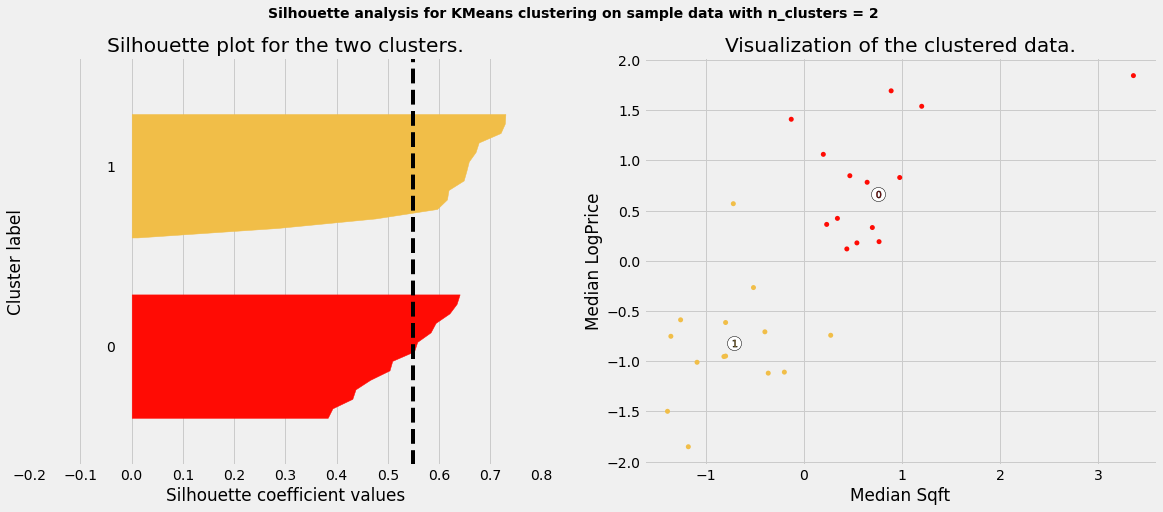

In [14]:
X = nhds
scaler = StandardScaler()
X = scaler.fit_transform(X)

inertias = []

range_n_clusters = [2]

for n_clusters in range_n_clusters:
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    ax1.set_xlim([-0.2, 0.8])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 5])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X, sample_weight=weights)
    
    inertias.append(clusterer.inertia_)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 5
    
    for i in range(n_clusters):
        
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
    
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_silhouette_dict[i]
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=1)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 5
        
    ax1.set_title("Silhouette plot for the two clusters.")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="black", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

    colors = [colors_silhouette_dict[cluster] for cluster in cluster_labels]
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=100, lw=0, alpha=1,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualization of the clustered data.")
    ax2.set_xlabel("Median Sqft")
    ax2.set_ylabel("Median LogPrice")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.savefig('two_clusters', bbox_inches='tight')
plt.show()